**Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model**

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
df = pd.read_csv("customer_churn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6197,1585-MQSSU,Male,0,No,No,17,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,No,Mailed check,51.50,900.5,Yes
3912,3882-IYOIJ,Female,0,Yes,Yes,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),115.25,6758.45,No
5145,3727-OVPRY,Male,0,Yes,Yes,66,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Credit card (automatic),25.70,1714.55,No
6071,0401-WDBXM,Male,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,...,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.55,7542.25,No
2171,3995-WFCSM,Female,0,No,No,2,Yes,No,DSL,No,...,Yes,No,No,Yes,Month-to-month,No,Electronic check,60.85,111.4,No


**First of all, drop customerID column as it is of no use**

In [3]:
df.drop('customerID',axis='columns',inplace=True)

In [4]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Quick glance at above makes me realize that TotalCharges should be float but it is an object. Let's check what's going on with this column**

In [5]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

**Ahh... it is string. Lets convert it to numbers**

In [6]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

**Hmmm... some values seems to be not numbers but blank string. Let's find out such rows**

In [7]:
pd.to_numeric(df.TotalCharges, errors = 'coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [8]:
df[pd.to_numeric(df.TotalCharges, errors = 'coerce').isnull()] # this will give all the rows with TotalCharges = ' '

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [9]:
df.shape

(7043, 20)

**Remove rows with space in TotalCharges**

In [10]:
df1 = df[df.TotalCharges != ' ']
df1.shape

(7032, 20)

In [11]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [12]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\973151263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.TotalCharges = pd.to_numeric(df1.TotalCharges)


In [13]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [15]:
df1[df1.Churn == 'No']
# Churn=='No' means no employee has left the company

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
6,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,No
7,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.90,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No


In [18]:
df1[df1.Churn == 'No'].tenure

0        1
1       34
3       45
6       22
7       10
        ..
7037    72
7038    24
7039    72
7040    11
7042    66
Name: tenure, Length: 5163, dtype: int64

In [19]:
tenure_churn_no = df1[df1.Churn == 'No'].tenure
tenure_churn_yes = df1[df1.Churn == 'Yes'].tenure

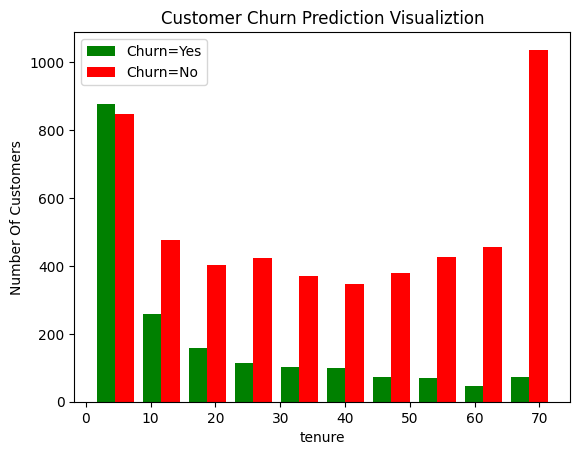

In [25]:
plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([tenure_churn_yes, tenure_churn_no], color = ['green', 'red'], label = ['Churn=Yes', 'Churn=No'])
plt.legend()

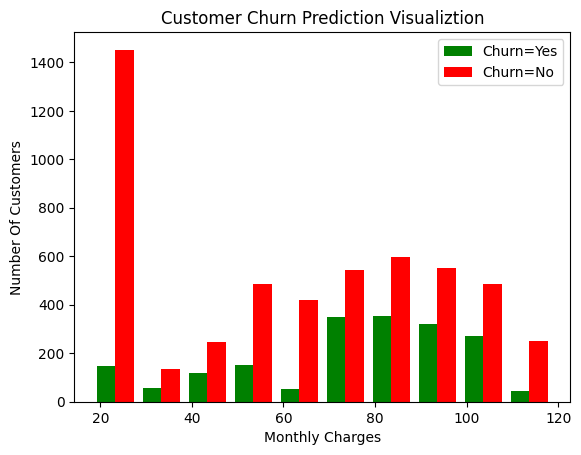

In [27]:
mc_churn_no = df1[df1.Churn=='No'].MonthlyCharges      
mc_churn_yes = df1[df1.Churn=='Yes'].MonthlyCharges      

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([mc_churn_yes, mc_churn_no], color=['green','red'],label=['Churn=Yes','Churn=No'])
plt.legend()

In [31]:
for column in df:
    print(f'{column} : {df[column].unique()}')

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2

In [32]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}') 

In [33]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**

In [37]:
df1.replace('No internet service', 'No', inplace = True)
df1.replace('No phone service', 'No', inplace = True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\494651664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No internet service', 'No', inplace = True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\494651664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.replace('No phone service', 'No', inplace = True)


In [38]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Convert Yes and No to 1 or 0**

In [39]:
yes_no_columns = ['Partner','Dependents','PhoneService','MultipleLines','OnlineSecurity','OnlineBackup',
                  'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': 1,'No': 0},inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\1648037665.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[col].replace({'Yes': 1,'No': 0},inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\1648037665.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1[col].replace({'Yes':

In [40]:
for col in df1:
    print(f'{col}: {df1[col].unique()}') 

gender: ['Female' 'Male']
SeniorCitizen: [0 1]
Partner: [1 0]
Dependents: [0 1]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [0 1]
MultipleLines: [0 1]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [0 1]
OnlineBackup: [1 0]
DeviceProtection: [0 1]
TechSupport: [0 1]
StreamingTV: [0 1]
StreamingMovies: [0 1]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [1 0]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [0 1]


In [41]:
df1['gender'].replace({'Female':1,'Male':0},inplace=True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\698335744.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['gender'].replace({'Female':1,'Male':0},inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_19196\698335744.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['gender'].repl

In [42]:
df1.gender.unique()

array([1, 0], dtype=int64)

**One hot encoding for categorical columns**

In [43]:
df2 = pd.get_dummies(data=df1, columns=['InternetService','Contract','PaymentMethod'])

In [45]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1696,0,0,0,0,3,1,1,0,0,0,...,False,True,False,True,False,False,False,False,True,False
5513,1,1,0,0,67,1,0,1,1,0,...,False,True,False,False,False,True,True,False,False,False
5035,0,0,0,0,20,1,0,0,0,0,...,False,True,False,True,False,False,False,False,True,False
716,1,0,1,0,71,0,0,0,1,1,...,True,False,False,False,False,True,True,False,False,False
5254,0,0,1,1,70,1,1,1,1,1,...,False,True,False,False,False,True,False,True,False,False


In [46]:
df2.dtypes

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
MultipleLines                                int64
OnlineSecurity                               int64
OnlineBackup                                 int64
DeviceProtection                             int64
TechSupport                                  int64
StreamingTV                                  int64
StreamingMovies                              int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                        int64
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No             

**Scaling**

In [56]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [57]:
for col in df2:
    print(f'{col} : {df2[col].unique()}')

gender : [1 0]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService : [0 1]
MultipleLines : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
Tech

# Train test split

X = df2.drop('Churn',axis='columns')
y = df2['Churn']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [59]:
X_train.shape

(5625, 26)

In [60]:
X_test.shape

(1407, 26)

In [61]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5664,1,1,0,0,0.126761,1,0,0,0,1,...,False,True,False,True,False,False,False,True,False,False
101,1,0,1,1,0.000000,1,0,0,0,0,...,False,False,True,True,False,False,False,False,True,False
2621,0,0,1,0,0.985915,1,0,0,1,1,...,True,False,False,False,False,True,False,True,False,False
392,1,1,0,0,0.014085,1,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
1327,0,0,1,0,0.816901,1,1,0,0,1,...,False,True,False,False,True,False,True,False,False,False
3607,1,0,0,0,0.169014,1,0,1,0,0,...,True,False,False,False,True,False,False,False,False,True
2773,0,0,1,0,0.323944,0,0,0,0,1,...,True,False,False,True,False,False,False,False,True,False
1936,1,0,1,0,0.704225,1,0,1,1,0,...,True,False,False,False,True,False,True,False,False,False
5387,0,0,0,0,0.042254,0,0,0,0,0,...,True,False,False,True,False,False,False,False,True,False
4331,0,0,0,0,0.985915,1,1,0,0,0,...,False,False,True,False,False,True,True,False,False,False


# Build a model (ANN) in tensorflow/keras



In [65]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(26, input_shape=(26,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

model.fit(X_train, y_train, epochs=100)

Epoch 1/100


C:\Program Files\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step - accuracy: 0.6144 - loss: 0.6291
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7858 - loss: 0.4301
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.8031 - loss: 0.4155
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.7963 - loss: 0.4197
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.7979 - loss: 0.4272
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.7964 - loss: 0.4229
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7988 - loss: 0.4182
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8023 - loss: 0.4175
Epoch 9/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.8081 - loss: 0.4049
Epoch 10/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.8026 - loss: 0.4121
Epoch 11/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 0.4000
Epoch 12/100
176/176 ━━━━━━━━━━━━━━

In [66]:
model.evaluate(X_test, y_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7932 - loss: 0.4730


[0.47511422634124756, 0.7796730399131775]

In [67]:
yp = model.predict(X_test)
yp[:5]

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[0.24308859],
       [0.42272246],
       [0.01178693],
       [0.9254378 ],
       [0.56720227]], dtype=float32)

In [68]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [69]:
y_pred[:10]

[0, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [70]:
y_test[:10]

2660    0
744     0
5579    1
64      1
3287    1
816     1
2670    0
5920    0
1023    0
6087    0
Name: Churn, dtype: int64

In [71]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       999
           1       0.63      0.58      0.60       408

    accuracy                           0.78      1407
   macro avg       0.73      0.72      0.73      1407
weighted avg       0.77      0.78      0.78      1407



Text(95.72222222222221, 0.5, 'Truth')

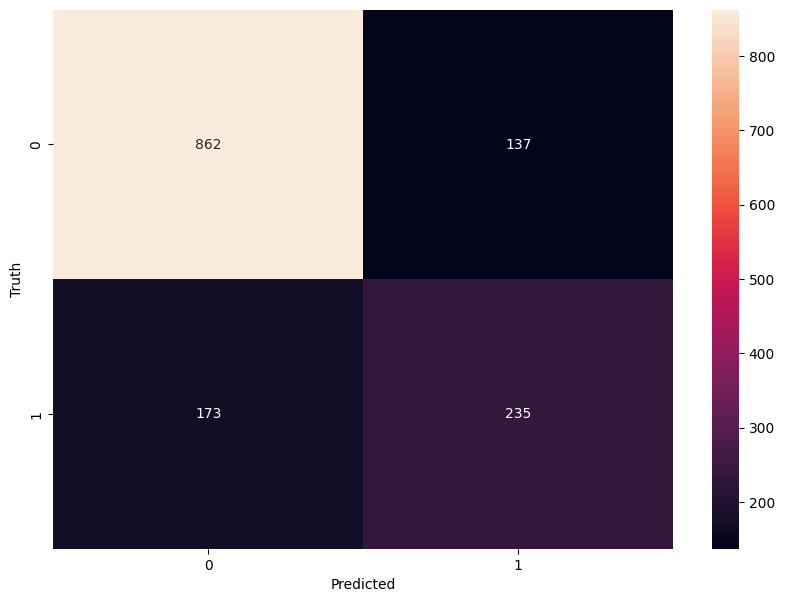

In [72]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')